# AI Feature API Getting Started Guide
This guide is aimed at providing practical assistance to a developer or data scientist getting up to speed on the AI Feature API.
Formal documentation is available on https://docs.nearmap.com/display/ND/NEARMAP+AI, and the swagger spec (detailed information for developers) is available via the [Knowledge Hub page](https://docs.nearmap.com/display/ND/AI+Feature+API).

In order to make use of these examples, you will need to have:
* The *Nearmap AI*, *AI Features API* and at least one relevant *AI Pack* available on your subscription.
* Your user must be enabled by the administrator to use Nearmap AI, including the AI Features API.

In [1]:
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import os
import glob
import pandas as pd
import json
import time
import numpy as np
import tqdm
import logging
from collections import OrderedDict

import geopandas as gpd
import shapely.geometry
import shapely.wkt

import matplotlib.colors


pd.set_option('max_colwidth', 80)

API_KEY = os.environ["API_KEY"] # Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.

FEATURES_URL = "https://api.nearmap.com/ai/features/v4/features.json"
CLASSES_URL = "https://api.nearmap.com/ai/features/v4/classes.json"

import matplotlib.pyplot as plt
%matplotlib inline

logging.root.setLevel(logging.WARNING)

In [2]:
s = requests.Session()

retries = Retry(total=7,
                backoff_factor=0.1,
                status_forcelist=[ 408, 429, 500, 502, 503, 504 ])

s.mount('https://', HTTPAdapter(max_retries=retries))

def get_payload(request_string):
    '''
    Basic wrapper code to retrieve the JSON payload from the API, and raise an error if no response is given.
    Using urllib3, this also implements exponential backoff and retries for robustness.
    '''
    response = s.get(request_string, )

    if response.ok:
        logging.info(f'Status Code: {response.status_code}')
        logging.info(f'Status Message: {response.reason}')
        payload = response.json()
        return payload
    else:
        logging.error(f'Status Code: {response.status_code}')
        logging.error(f'Status Message: {response.reason}')
        logging.error(str(response))
        payload = response.content
        logging.error(str(payload))
        return None

# Prepare Requested Parcel Polygons
Here we prepare a set of custom parcel polygons for use with the API. Each one represents a custom "Query AOI", which in this case represents one property parcel.

Note that all our AI data is in EPSG:4326 latitude/longitude coordinates. You may wish to take epoch into account (as at the survey_date provided by a given example) if transforming into a local coordinate referenced, to get the best geospatial accuracy. As presented, these results will align perfectly with the Nearmap imagery survey from which they were produced without adjustment.

In [3]:
df_parcels = [
    {'parcel_id': 1, 'description': 'Chicago Houses', 'geometry':  'POLYGON ((-87.73101994900836 41.79082699478777, -87.73056822386012 41.79083207215124, -87.73055971145155 41.79050035022655, -87.73101767903275 41.79047834820146, -87.73101767903275 41.79047834820146, -87.73101994900836 41.79082699478777))'},    
    {'parcel_id': 2, 'description': 'Seattle Waterfront', 'geometry': 'POLYGON ((-122.2823152599673620 47.6425989476305460, -122.2815272810569809 47.6425879850246901, -122.2815400653755802 47.6416851282309679, -122.2817295057330682 47.6416929587992897, -122.2819305681984048 47.6416984401964214, -122.2822617982713780 47.6416279650466308, -122.2823617483986567 47.6418777598710506, -122.2823617483986567 47.6418777598710506, -122.2823152599673620 47.6425989476305460))'},
    {'parcel_id': 3, 'description': 'Omaha Townhouse', 'geometry': 'POLYGON ((-96.1740037210934844 41.1921154159583125, -96.1737268975775521 41.1923035677673823, -96.1736635518738154 41.1922586297728515, -96.1739322827667991 41.1920435989421705, -96.1739322827667991 41.1920435989421705, -96.1740037210934844 41.1921154159583125))'},
    {'parcel_id': 4, 'description': 'Omaha School', 'geometry': 'POLYGON ((-122.3048054289578630 47.6231333866878757, -122.3048398074655267 47.6203153293018104, -122.3058552956924245 47.6205506188424508, -122.3072753925097231 47.6205541838273447, -122.3072225024979076 47.6231422987093609, -122.3072225024979076 47.6231422987093609, -122.3048054289578630 47.6231333866878757))'},
    {'parcel_id': 5, 'description': 'Bella Vista Apartments, Dallas', 'geometry': 'Polygon ((-96.88968861 33.00461791, -96.88611496 33.00547017, -96.8857576 33.00486454, -96.88580227 33.00234207, -96.88965511 33.00355024, -96.88968861 33.00461791))'},
    {'parcel_id': 6, 'description': 'Enchanted Hill Park, Dallas', 'geometry': 'Polygon ((-96.901188 33.03515047, -96.90301097 33.0369661, -96.90472234 33.0357002, -96.90346587 33.03437984, -96.901188 33.03515047))'},
    {'parcel_id': 7, 'description': 'Buckle Up Mobile Home Park, Dallas', 'geometry': 'Polygon ((-96.93598654 33.03668188, -96.93937386 33.03668188, -96.9393704 33.03790136, -96.93794689 33.03832237, -96.93601772 33.03847625, -96.93598654 33.03668188))'},
    {'parcel_id': 8, 'description': '1km2 AOI Omaha', 'geometry': 'Polygon ((-96.19862826921800547 41.21522079378620873, -96.19861286939449485 41.22358358960185853, -96.18481392344685332 41.22355261526949732, -96.18482932327036394 41.21518981945384752, -96.19862826921800547 41.21522079378620873))'},
    {'parcel_id': 9, 'description': '2.2km2 AOI Omaha', 'geometry': 'Polygon ((-96.19832311527790125 41.20669631678963185, -96.19861286939449485 41.22358358960185853, -96.18481392344685332 41.22355261526949732, -96.18452416933025972 41.20666534245727064, -96.19832311527790125 41.20669631678963185))'},
    {'parcel_id': 10, 'description': '4km2 AOI Omaha', 'geometry': 'Polygon ((-96.20949174948532345 41.20675752703589012, -96.20978150360191705 41.2236447998481168, -96.18481392344685332 41.22355261526949732, -96.18452416933025972 41.20666534245727064, -96.20949174948532345 41.20675752703589012))'},
]

df_parcels = pd.DataFrame(df_parcels).set_index('parcel_id')
df_parcels['geometry'] = df_parcels.geometry.apply(lambda s: shapely.wkt.loads(s))
df_parcels = gpd.GeoDataFrame(df_parcels, crs='EPSG:4326')
df_parcels

,description,geometry
parcel_id,,
1,Chicago Houses,"POLYGON ((-87.73102 41.79083, -87.73057 41.79083, -87.73056 41.79050, -87.73..."
2,Seattle Waterfront,"POLYGON ((-122.28232 47.64260, -122.28153 47.64259, -122.28154 47.64169, -12..."
3,Omaha Townhouse,"POLYGON ((-96.17400 41.19212, -96.17373 41.19230, -96.17366 41.19226, -96.17..."
4,Omaha School,"POLYGON ((-122.30481 47.62313, -122.30484 47.62032, -122.30586 47.62055, -12..."
5,"Bella Vista Apartments, Dallas","POLYGON ((-96.88969 33.00462, -96.88611 33.00547, -96.88576 33.00486, -96.88..."
6,"Enchanted Hill Park, Dallas","POLYGON ((-96.90119 33.03515, -96.90301 33.03697, -96.90472 33.03570, -96.90..."
7,"Buckle Up Mobile Home Park, Dallas","POLYGON ((-96.93599 33.03668, -96.93937 33.03668, -96.93937 33.03790, -96.93..."
8,1km2 AOI Omaha,"POLYGON ((-96.19863 41.21522, -96.19861 41.22358, -96.18481 41.22355, -96.18..."
9,2.2km2 AOI Omaha,"POLYGON ((-96.19832 41.20670, -96.19861 41.22358, -96.18481 41.22355, -96.18..."


# Discover Available Classes: The "classes.json" endpoint
The "classes" endpoint is simple - it doesn't take any query parameters, and simply provides the list of IDs and Descriptions for every feature class you have access to on your account. If you add a new AI Pack, or we add new feature classes to your existing AI Packs, this will expand over time.

In [4]:
request_string = f"{CLASSES_URL}?apikey={API_KEY}"
classes_payload = get_payload(request_string)
df_classes = pd.DataFrame(classes_payload['classes']).sort_values('internalId').set_index('id')

# Only displaying the top ten classes for brevity.
df_classes.head(10)

,type,internalId,description,schema
id,,,,
89c7d478-58de-56bd-96d2-e71e27a36905,Attribute,3,Roof material,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
20a58db2-bc02-531d-98f5-451f88ce1fed,Attribute,4,Roof types,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
7ab56e15-d5d4-51bb-92bd-69e910e82e56,Attribute,5,Roof tree overhang,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
39072960-5582-52af-9051-4bc8625ff9ba,Attribute,7,Roof 3d attributes,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
19e49dad-4228-554e-9f5e-c2e37b2e11d9,Attribute,8,Building 3d attributes,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
3065525d-3f14-5b9d-8c4c-077f1ad5c694,Attribute,10,Roof condition,"{'type': 'object', 'properties': {'classId': {'type': 'string'}, 'descriptio..."
2e0bd9e3-3b67-4990-84dc-1b4812fdd02b,Feature,1000,Water Body,NaN
0339726f-081e-5a6e-b9a9-42d95c1b5c8a,Feature,1001,Swimming Pool,NaN
c08255a4-ba9f-562b-932c-ff76f2faeeeb,Feature,1002,Roof,NaN


# Bring Your Own Parcels: The "features.json" endpoint
This endpoint is the best one to use if you have access to your own parcel database. Usually, this will either be a local government entity who manages their own parcels, a parcel provider, or a larger organisation such as an insurance carrier with some level of GIS capability in house that has aligned with a particular provider's parcels as their internal source of truth for property boundaries. No property boundary data is used behind the scenes to produce this data, other than an "on-the-fly" query with the polygon you provide to the endpoint.

## Get a first API Response
Assuming you have the `API_KEY` environment variable set to your Nearmap API Key. This API Key can be the same as the one used to access imagery, as long as it is pointing to the subscription on which you have Nearmap AI set up.

### Input Parameters
The key parameters of interest are:
* `polygon`: A comma separated list of lon1,lat1,lon2,lat2... in EPSG:4326, representing the "Query AOI". Multi-polygons are not supported - a single outer ring. Highly complex geometries with many points may take longer to query. Larger Query AOIs will take longer.
* `since`: (optional) instructs the API to ignore any AI results prior to date `yyyy-mm-dd`. Default is unrestricted.
* `until`: (optional) instructs the API to ignore any AI results after date `yyyy-mm-dd`. Default is unrestricted. The most recent processed AI results will be returned, optionally constrained by `since` and `until` (if both are provided, the most recent processed result within that window is returned.
* `packs`: (optional) restricts data to certain AI Packs as described in https://docs.nearmap.com/display/ND/AI+Packs. Default is to provide data for all AI Packs enabled on your account.
* `apikey`: Nearmap API Key.

In [5]:
def poly2coordstring(poly):
    '''
    Turn a shapely polygon into the format required by the API for a query polygon.
    '''
    coords = poly.boundary.coords[:]
    flat_coords = np.array(coords).flatten()
    coordstring = ','.join(flat_coords.astype(str))
    return coordstring

'Visualisation of the Query AOI:'

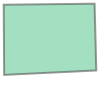

'WKT of Query AOI: POLYGON ((-87.7310199490083562 41.7908269947877713, -87.7305682238601179 41.7908320721512396, -87.7305597114515479 41.7905003502265515, -87.7310176790327461 41.7904783482014608, -87.7310176790327461 41.7904783482014608, -87.7310199490083562 41.7908269947877713))'

'API formatted Query AOI: -87.73101994900836,41.79082699478777,-87.73056822386012,41.79083207215124,-87.73055971145155,41.79050035022655,-87.73101767903275,41.79047834820146,-87.73101767903275,41.79047834820146,-87.73101994900836,41.79082699478777'

In [6]:
# Get a shapely polygon object for the first query AOI in our data frame, and convert it into the right format for the API.

poly_obj = df_parcels.loc[1, 'geometry']
poly_obj
display('Visualisation of the Query AOI:')
display(poly_obj)
display(f'WKT of Query AOI: {shapely.wkt.dumps(poly_obj)}')
polygon = poly2coordstring(poly_obj)
display(f'API formatted Query AOI: {polygon}')

In [7]:
# Specify the optional date range
SINCE, UNTIL = ('2016-01-01', '2021-03-31')

In [8]:
# Specify the AI Packs. This list represents all AI Packs that are currently available.

PACKS = 'pool,solar,building,building_char,roof_char,roof_cond,construction,trampoline,vegetation,surfaces'

In [9]:
request_string = f"{FEATURES_URL}?polygon={polygon}&since={SINCE}&until={UNTIL}&packs={PACKS}&apikey={API_KEY}"
response = s.get(request_string)

print('Request string (with API KEY removed):')
print(request_string[:-len(API_KEY)])

Request string (with API KEY removed):
https://api.nearmap.com/ai/features/v4/features.json?polygon=-87.73101994900836,41.79082699478777,-87.73056822386012,41.79083207215124,-87.73055971145155,41.79050035022655,-87.73101767903275,41.79047834820146,-87.73101767903275,41.79047834820146,-87.73101994900836,41.79082699478777&since=2016-01-01&until=2021-03-31&packs=pool,solar,building,building_char,roof_char,roof_cond,construction,trampoline,vegetation,surfaces&apikey=


In [17]:
%%timeit

# NB: The time below indicates the delay for a residential internet connection in Australia querying a US parcel, with all AI Packs enabled.
payload = get_payload(request_string)

335 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
payload = get_payload(request_string)

### Understanding the Payload
Let's go through each of the top level sections of the response payload (i.e. the keys in the json file), and understand them as we go.


In [19]:
payload.keys()

dict_keys(['credits', 'systemVersion', 'features', 'link'])

#### credits
The number of Nearmap AI credits used in the query. Typically, a single property will correspond to 1 credit. Larger or composite custom parcels may consume more credits. Buffering the parcel polygon to check what is present nearby will also consume more credits (a single property surrounded by a grid of 9 properties will consume 10 credits if a buffer is used that is the size of a whole property. Note that credits will only be charged if a valid response is returned (e.g. if no AI data matches the query, an empty result is returned, and no credits are charged).

In [20]:
payload['credits']

3

#### systemVersion
The version of the data (which includes the machine learning model, post processing algorithms, and processing pipeline configuration). This is tied to the data, rather than the API (different requests from the same endpoint may retrieve different versions of data at various times/locations). A detailed changelog of AI System data versions can be found on knowledge hub under https://docs.nearmap.com/display/ND/AI+Content.

New attributes and changes are introduced from time to time, so please consider carefully how your application deals with versions.

In [21]:
payload['systemVersion']

'gen4-building_storm-1.0'

#### link
A link to the location in Map Browser (based on both image capture date and lat/lon of parcel centre). This is _exceptionally_ useful for troubleshooting, understanding whether the Nearmap AI result or some other internal data source is correct, and understanding why the Nearmap AI result may be wrong in some circumstances. We recommend enabling the relevant AI Layers after clicking the link, exploring different dates using the date picker, or using the 3D or oblique views.

In [22]:
payload['link']

'https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007'

#### Features
The "features" is the meat of the payload, containing all the geospatial objects (features), and information about them (attributes) in a flat list. Each feature has:
* `surveyDate` is the date of the survey which captured the image used in producing the data. All Nearmap AI data is calculated against a specific point in time.
* A unique `id` that identifies the feature, which is very useful for deduplicating identical features returned from nearby API requests, or joining cropped "large objects" in the `surfaces` and `vegetation` packs.
* A `classId` and `description` that describe what type of feature it is. The `classId` should be used within code (as a persistent ID for all features of that type), and the `description` is the human readable reference (which is not guaranteed to be persistent).
* `confidence` is the probability (float range 0-1) that the feature is in fact a real object of type `classId`. This is useful for determining a threshold for objects such as buildings. Typical confidence distributions can be found in https://docs.nearmap.com/display/ND/AI+Packs#AIPacks-Confidencetalk-677. For example, most solar panels are well above 90% confidence - solar panels with 50-70% confidence may either be difficult to spot (high glare, shadow etc.), or be a similar type of object such as a solar hot water system or skylight.
* `parentId` describes the relationship between features. All features within the custom parcel polygon are provided in a flat list. The `parentId` is blank for many features. However, ones that are heirarchically nested (a roof on a building, a tree overhang, roof material, roof type or solar panel on a roof). For example, a solar panel on a roof will have that roof's `id` as it's parent. A solar panel on the ground will have an empty `parentId`. This is a little more nuanced in structure than simple spatial overlap queries (e.g. tree overhang parents are roofs, and roof parents are buildings, despite them all overlapping).
* `geometry`: The geometry is an EPSG:4326 polygon describing the extent of the feature in 2D.
* `attributes`: Some features have particular metadata calculated about them. Buildings, for example, have a `Roof Material` attribute, which has a `dominantComponent` (the best estimate of the material covering the majority of the roof) as well as `components` describing the proportion and confidence of each material present on the roof.

In [23]:
payload['features'][0] # First feature in the payload

{'id': '91569a68-a309-56b3-9c2c-50e76fd95c63',
 'classId': 'a2e4ae39-8a61-5515-9d18-8900aa6e6072',
 'description': 'Building',
 'confidence': 0.998046875,
 'parentId': '',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-87.73092694580555, 41.79062530129026],
    [-87.73103021085262, 41.79062530129026],
    [-87.73103021085262, 41.790686295616766],
    [-87.73092694580555, 41.790686295616766],
    [-87.73092694580555, 41.79062530129026]]]},
 'areaSqm': 58.2,
 'areaSqft': 626,
 'attributes': [{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9',
   'description': 'Building 3d attributes',
   'has3dAttributes': True,
   'height': 3.4962478637695313,
   'numStories': {'1': 0.9574999630451057,
    '2': 0.04250003695489444,
    '3+': 0}}],
 'surveyDate': '2020-10-07',
 'meshDate': '2020-03-07'}

## Whole Payload
This is the representation of the entire payload for a single Query AOI.

In [24]:
json.dumps(payload)

'{"credits": 3, "systemVersion": "gen4-building_storm-1.0", "features": [{"id": "91569a68-a309-56b3-9c2c-50e76fd95c63", "classId": "a2e4ae39-8a61-5515-9d18-8900aa6e6072", "description": "Building", "confidence": 0.998046875, "parentId": "", "geometry": {"type": "Polygon", "coordinates": [[[-87.73092694580555, 41.79062530129026], [-87.73103021085262, 41.79062530129026], [-87.73103021085262, 41.790686295616766], [-87.73092694580555, 41.790686295616766], [-87.73092694580555, 41.79062530129026]]]}, "areaSqm": 58.2, "areaSqft": 626, "attributes": [{"classId": "19e49dad-4228-554e-9f5e-c2e37b2e11d9", "description": "Building 3d attributes", "has3dAttributes": true, "height": 3.4962478637695313, "numStories": {"1": 0.9574999630451057, "2": 0.04250003695489444, "3+": 0}}], "surveyDate": "2020-10-07", "meshDate": "2020-03-07"}, {"id": "02271d09-b3a1-5fd4-a618-80e342bcb719", "classId": "c08255a4-ba9f-562b-932c-ff76f2faeeeb", "description": "Roof", "confidence": 0.998046875, "parentId": "4fb92c5f-

### Visualising the Payload
This is a convenient way of visualising the payload's results, and exporting into a geospatial file for use with a GIS system.

In [25]:
# Subset of available classes for visualisation. Note that in a robust application, you should always code against the "classId" rather than the "description". We do this here for clarity and readability, but description text may change over time (e.g. "solar panel" may change to "Solar PV Panel", whereas 'classId' is a robust, unique identifier for each class.

FEATURE_CLASS_ID_WATER_BODY = '2e0bd9e3-3b67-4990-84dc-1b4812fdd02b'
FEATURE_CLASS_ID_SWIMMING_POOL = '0339726f-081e-5a6e-b9a9-42d95c1b5c8a'
FEATURE_CLASS_ID_BUILDING = 'a2e4ae39-8a61-5515-9d18-8900aa6e6072'
FEATURE_CLASS_ID_MED_HIGH_VEG = 'dfd8181b-80c9-4234-9d05-0eef927e3aca'
FEATURE_CLASS_ID_TREE_OVERHANG = '8e9448bd-4669-5f46-b8f0-840fee25c34c'
FEATURE_CLASS_ID_SOLAR_PANEL = '3680e1b8-8ae1-5a15-8ec7-820078ef3298'
class_list = [
    FEATURE_CLASS_ID_WATER_BODY,
    FEATURE_CLASS_ID_SWIMMING_POOL,
    FEATURE_CLASS_ID_BUILDING,
    FEATURE_CLASS_ID_MED_HIGH_VEG,
    FEATURE_CLASS_ID_TREE_OVERHANG,
    FEATURE_CLASS_ID_SOLAR_PANEL,
]

class_dic = OrderedDict((
    ('Parcel Polygon', '#eeeeee'),
    ('Water Body', '#00cee3'),
    ('Swimming Pool', '#a6cee3'),
    ('Trampoline', '#e31a1c'),
    ('Construction Site','#e7298a'),
#     ('Building', '#b15928'), 
    ('Roof', '#ff7f00'),
#     ('Metal Roof', '#b2df8a'),
#     ('Shingle Roof', '#fdbf6f'),
#     ('Tile Roof','#fb9a99'),
    ('Medium & High Vegetation (>2m)','#00ff00'),
    ('Tree Overhang','#33a02c'),
    ('Solar Panel','#ffff99'),
))

class_list = list(class_dic.keys())
colour_list = list(class_dic.values())
cmap = matplotlib.colors.ListedColormap(colour_list)

class_dic # Set up colours for display.

OrderedDict([('Parcel Polygon', '#eeeeee'),
             ('Water Body', '#00cee3'),
             ('Swimming Pool', '#a6cee3'),
             ('Trampoline', '#e31a1c'),
             ('Construction Site', '#e7298a'),
             ('Roof', '#ff7f00'),
             ('Medium & High Vegetation (>2m)', '#00ff00'),
             ('Tree Overhang', '#33a02c'),
             ('Solar Panel', '#ffff99')])

In [26]:
def get_parcel_as_geodataframe(payload, parcel_poly):
    '''
    Convert each feature in the payload into a row of a geopandas GeoDataFrame, and its attributes as a nested dictionary parsed from the json as an "attributes" column.
    '''
    df_features = [{'geometry': parcel_poly, 'description': 'Parcel Polygon', 'classId': 0, 'link': '', 'systemVersion': payload["systemVersion"], 'confidence': 1}]

    for feature in payload['features']:
        poly = shapely.geometry.shape(feature['geometry'])
        feature_tmp = feature.copy()
        feature_tmp['geometry'] = poly
        
        feature_tmp['parentId'] = str(feature['parentId'])
        feature_tmp['link'] = payload['link']
        feature_tmp['systemVersion'] = payload['systemVersion']
        if 'attributes' in feature:
            feature_tmp['attributes'] = feature['attributes']
        df_features.append(feature_tmp)

    df_features = gpd.GeoDataFrame(df_features, crs='EPSG:4326')
    df_features['description'] = pd.Categorical(df_features.description)
    df_features = df_features.sort_values('description')
    return df_features

def process_payload(payload, poly_obj, out_name, save=True):
    '''
    Visualise payload as a dataframe and plot, and export as a geopackage file.
    '''

    df_features = get_parcel_as_geodataframe(payload, poly_obj)
        
    if save:
        with open(f"{out_name}.json", 'w') as f:
            json.dump(payload, f)

        df_features_saveable = (df_features.assign(
            description=df_features.description.astype('str'),
        ))
        if len(df_features) > 1: # Not just parcel polygon
            df_features_saveable['attributes'] = df_features_saveable.attributes.apply(lambda j: json.dumps(j, indent=2)) # Render attributes as string so it can be saved as a geopackage
        df_features_saveable.to_file(f"{out_name}.gpkg", driver="GPKG")
    return df_features


def plot_query_aoi(df_features, class_list=class_list, min_confidence=0.7):
    df_features_plot = df_features.copy()    
    df_features_plot['description'] = pd.Categorical(df_features['description'], categories=class_dic.keys(), ordered=True) # Restrict categories for visualisation
    df_features_plot = df_features_plot.dropna(subset=['description']).sort_values('description')
    colours = df_features_plot.description.apply(lambda d: class_dic[d])
    (df_features_plot
     .loc[df_features.confidence > min_confidence]
     .plot(figsize=(20,20), cmap=cmap, column='description', legend=True, categorical=True)
    )
    plt.xticks([])
    plt.yticks([])
    plt.show()


def explore_example_parcel(ind, df_request_polygons, since=SINCE, until=UNTIL, packs=PACKS):
    '''
    From a geopandas Geodataframe of sample polygons, choose an index to visualise, and return a geodataframe of all features contained within it.
    '''
    poly_obj = df_request_polygons.loc[ind, 'geometry']
    polygon = poly2coordstring(poly_obj)
    desc = df_request_polygons.loc[ind,'description']
    request_string = f"{FEATURES_URL}?polygon={polygon}&since={since}&until={until}&packs={packs}&apikey={API_KEY}"
    logging.info(request_string.split('&apikey')[0])
    t1 = time.time()
    payload = get_payload(request_string)
    t2 = time.time()
    logging.info(f'Time to retrieve payload: {t2-t1:0.2f}s')
    logging.info(f'Credits used: {payload["credits"]}')
    logging.info(f'System version: {payload["systemVersion"]}')
    logging.debug(f'Payload: {payload}')
    
    df_features = process_payload(payload, poly_obj, f'sample_payload_{desc}', save=False)
    plot_query_aoi(df_features)

    return df_features


def remove_exterior_features(df_features, albers_proj, frac_of_parcel_filled_by_feature_thresh=0.5, frac_of_feature_within_parcel_thresh=0.5, parcel_feature_intersection_minimum_m2=20):
    '''
    An example algorithm for removing features from a query AOI, if they are deemed to only be included due to e.g. a parcel shift error.
    The total area of the feature within a parcel is meaningful, as some buildings may legitimately extend across multiple parcels (but at least @parcel_feature_intersection_minimum_m2 is required).
    Some features such as swimming pools often lie on a fence line, so they are best assigned based on whether half the object's area falls within the query AOI, and should not be shared between parcels.
    Lastly, some query AOIs are very small (e.g. very small parcels), and it is sufficient if the majority of the parcel is filled by the object, regardless of absolute size.
    
    Note that some AI Packs (Vegetation and Surfaces) that contain contiguous, potentially large areas, have results that are cropped to the query AOI. This is to ensure that a whole ocean or forest is not returned with a single query.
    '''
    df_features['area_m2'] = df_features.to_crs(ALBERS_PROJ).area
    parcel_area_m2 = df_features.loc[0, 'area_m2']
    feature_parcel_intersections = df_features.geometry.intersection(df_features.loc[0,'geometry'])
    df_features['feature_parcel_intersection_area_m2'] = feature_parcel_intersections.to_crs(ALBERS_PROJ).area
    df_features['frac_of_parcel_filled_by_feature'] = df_features.feature_parcel_intersection_area_m2 / parcel_area_m2
    df_features['frac_of_feature_within_parcel'] = df_features.feature_parcel_intersection_area_m2 / df_features.area_m2
    df_features['keep'] = (df_features.frac_of_parcel_filled_by_feature > frac_of_parcel_filled_by_feature_thresh) | (df_features.frac_of_feature_within_parcel > frac_of_feature_within_parcel_thresh) | (df_features.feature_parcel_intersection_area_m2 > parcel_feature_intersection_minimum_m2)
    
    # Now remove any remaining features that have their parent as a building which was removed, e.g. a bit of tree overhang
    df_removed_buildings = df_features.query('(description in ("Building", "Roof")) & ~keep')
    for removed_building in df_removed_buildings.itertuples():
        df_features.loc[df_features.parentId == removed_building.id, 'keep'] = False
    df_features = df_features.query('keep')
    return df_features

# Explore some examples
Now we move through each of the sample parcel boundaries, to show a variety of cases.

### Example ID 1 (Chicago Houses)
This example is an artificial hand drawn boundary around approximately 3 residential properties. It showcases a common issue with parcel boundaries. Where the parcel boundary is shifted relative to ground, it is reasonably common to retrieve a feature that clearly belongs to a neighbouring parcel, or to have a legitimate feature that extends beyond the queried parcel by some amount. While the on-the-ground accuracy of the imagery and AI can cause this, it is more commonly caused by parcel boundaries that have been digitised incorrectly (and there is a high degree of local variability in this!). One method to deal with this is to ignore any objects where area of the intersection of the feature and the parcel is small compared to the area of the feature, AND small compared to the size of the parcel. This allows you to retain small features that lie almost completely within the parcel, as well as large multi-parcel buildings, where enough of the building protrudes into the parcel that the parcel "substantially" contains some of the building.

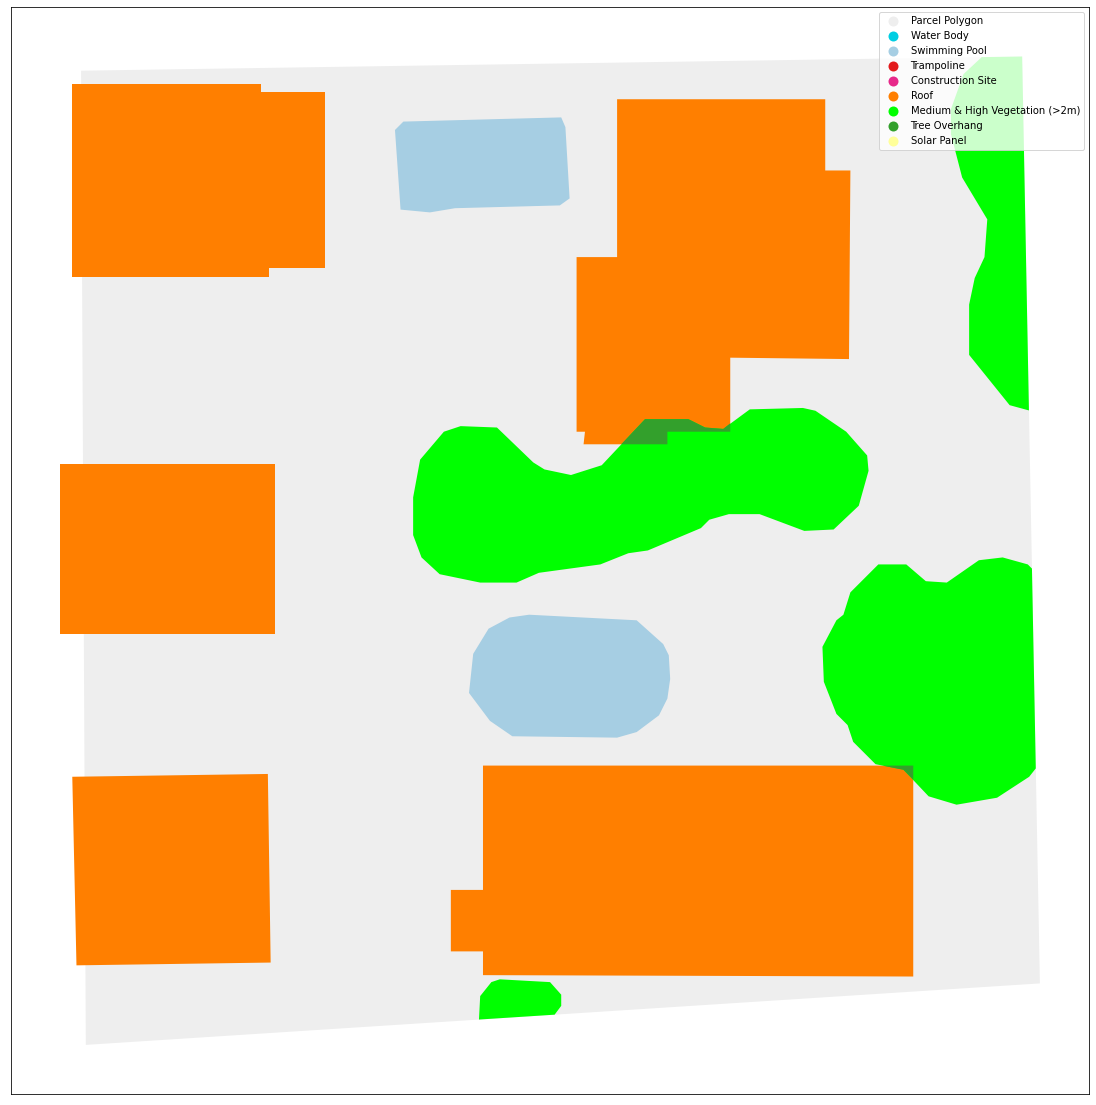

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
18,"POLYGON ((-87.73093 41.79075, -87.73102 41.79075, -87.73102 41.79082, -87.73...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007",gen4-building_storm-1.0,0.998047,2cc7e4be-59a1-5dcf-876f-6962574d1dcc,,75.7,815.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-10-07,2020-03-07
24,"POLYGON ((-87.73093 41.79063, -87.73103 41.79063, -87.73103 41.79069, -87.73...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007",gen4-building_storm-1.0,0.998047,91569a68-a309-56b3-9c2c-50e76fd95c63,,58.2,626.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-10-07,2020-03-07
28,"POLYGON ((-87.73093 41.79051, -87.73102 41.79051, -87.73102 41.79057, -87.73...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007",gen4-building_storm-1.0,0.998047,6559da73-d0d2-54ae-beed-035ff37fa0d2,,58.3,628.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-10-07,2020-03-07
36,"POLYGON ((-87.73084 41.79053, -87.73083 41.79053, -87.73083 41.79058, -87.73...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007",gen4-building_storm-1.0,0.998047,4fb92c5f-84bf-5e4e-bee8-5df272e56a75,,146.6,1578.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-10-07,2020-03-07
9,"POLYGON ((-87.73078 41.79076, -87.73076 41.79076, -87.73076 41.79082, -87.73...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.7906590,-87.7307932,20.00z,0d/V/20201007",gen4-building_storm-1.0,0.994141,3e6aae0c-7f55-52e3-90eb-b386e35100fe,,118.9,1280.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-10-07,2020-03-07


In [27]:
df_features = explore_example_parcel(1, df_parcels)
df_features.head()

### Example ID 2 (Seattle)
This is a waterfront property, with a large, reasonably complex residential home. Note that this was a hand drawn polygon, and it uses two credits, because it covers what are technically two smaller parcels. We then calculate the number of square metres of water body within 30 metres of the building.

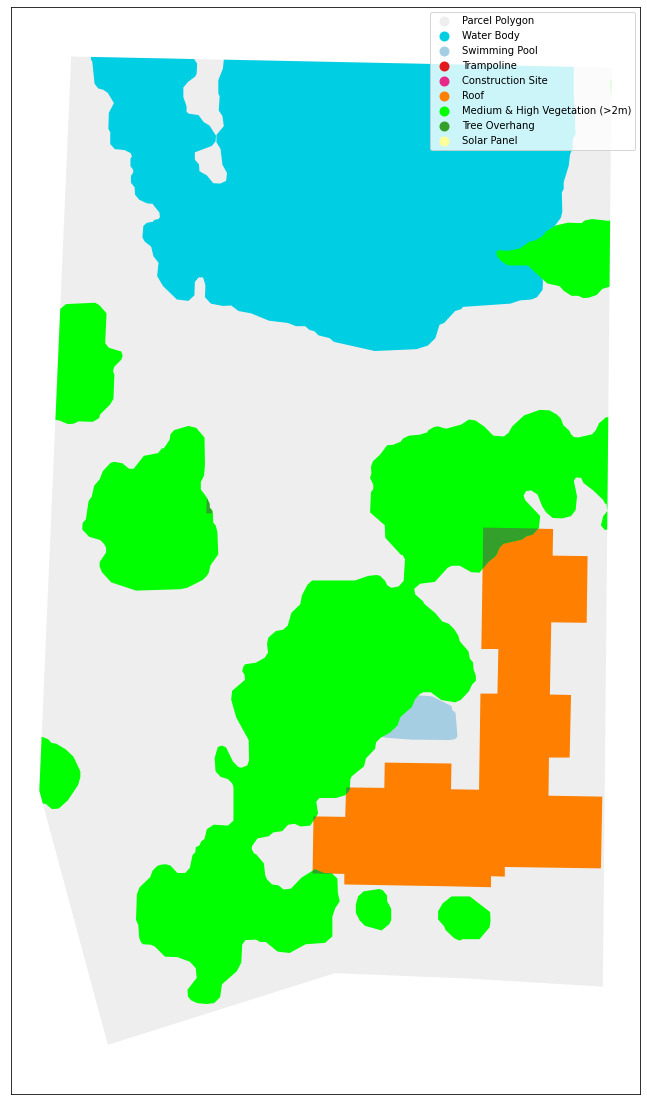

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
20,"POLYGON ((-122.28155 47.64215, -122.28155 47.64214, -122.28155 47.64213, -12...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6421362,-122.2819388,20.00z,0d/V/20200829",gen4-building_storm-1.0,0.650391,7b7d9d10-fc21-528a-900b-cc985b718aa9,,7.7,82.0,[],2020-08-29,2020-05-27
26,"MULTIPOLYGON (((-122.28236 47.64187, -122.28235 47.64186, -122.28235 47.6418...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6421362,-122.2819388,20.00z,0d/V/20200829",gen4-building_storm-1.0,0.982422,33a31363-f47f-54bf-a950-15d3fb035919,,18.6,200.0,[],2020-08-29,2020-05-27
22,"POLYGON ((-122.28204 47.64210, -122.28205 47.64208, -122.28206 47.64208, -12...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@47.6421362,-122.2819388,20.00z,0d/V/20200829",gen4-building_storm-1.0,0.552734,002e47b3-2e33-5f41-a465-ee789a224b64,,3.3,35.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-08-29,2020-05-27
23,"POLYGON ((-122.28169 47.64197, -122.28169 47.64202, -122.28172 47.64202, -12...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@47.6421362,-122.2819388,20.00z,0d/V/20200829",gen4-building_storm-1.0,0.994141,73db27d1-428c-587a-8290-ea7f6902a662,,564.7,6079.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-08-29,2020-05-27
25,"POLYGON ((-122.28211 47.64215, -122.28212 47.64215, -122.28212 47.64217, -12...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@47.6421362,-122.2819388,20.00z,0d/V/20200829",gen4-building_storm-1.0,0.556641,bd130058-e2c4-58d8-8176-f58e9f994118,,1.3,14.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-08-29,2020-05-27


In [28]:
df_features = explore_example_parcel(2, df_parcels)
df_features.head()

In [29]:
# Convert to the North American "Albers Equal Area" projection for more accurate areas
ALBERS_PROJ = 'ESRI:102008'
df_features = df_features.to_crs(ALBERS_PROJ)

Area of water body in parcel: 1282.3m2


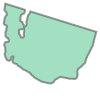

In [30]:
poly_water = df_features.query('description == "Water Body"').geometry.iloc[0]
print(f'Area of water body in parcel: {poly_water.area:.1f}m2')
poly_water

Area of building: 564.7m2


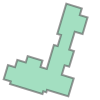

In [31]:
poly_building = df_features.query('description == "Building" & confidence > 0.9').geometry.iloc[0]
print(f'Area of building: {poly_building.area:.1f}m2')
poly_building

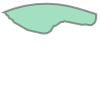

Area of water body within 30 metres of building: 129.9m2


In [32]:
poly_water_within_30m = poly_building.buffer(30).intersection(poly_water)
display(poly_water_within_30m)
print(f'Area of water body within 30 metres of building: {poly_water_within_30m.area:.1f}m2')


### Example ID 3 (Omaha Townhouse)
This is a single parcel for a townhouse where the building extends over three blocks. It's important to ensure you don't discard buildings like this, and make a decision on whether to "crop" the building to the parcel (for the part of it belonging to this owner), or wish to analyse the building as a whole.

In this example, the building passes the above tests that we want it included, but an explicit decision is needed - are we interested in the whole physically connected building (which exists substantially both within and without the parcel), or just that part which falls within the parcel?

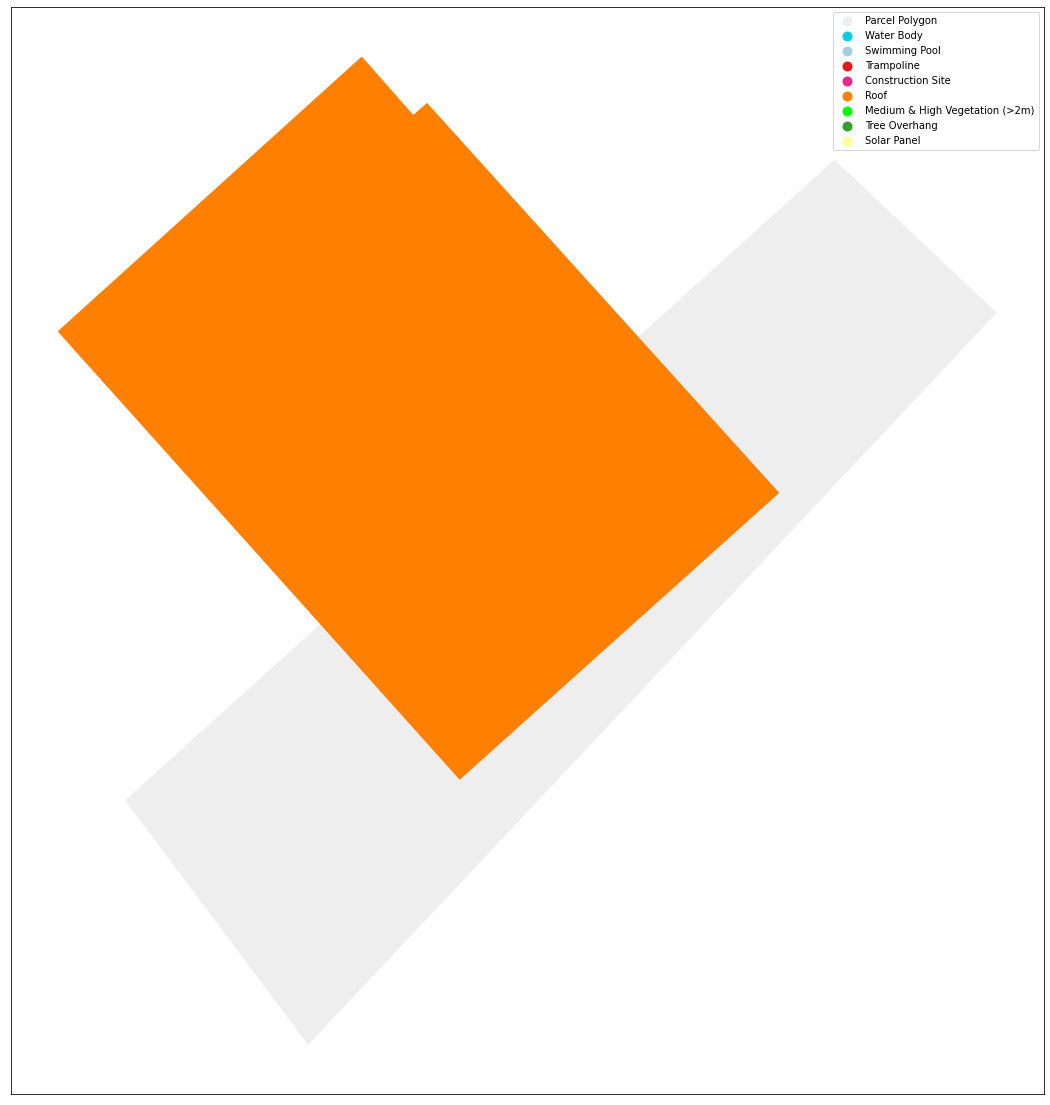

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
1,"POLYGON ((-96.17375 41.19221, -96.17387 41.19212, -96.17403 41.19225, -96.17...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@41.1921750,-96.1738383,20.00z,0d/V/20200727",gen4-building_storm-1.0,0.998047,61ed295b-7d00-519d-b6e9-e32a44cfebac,,274.4,2953.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-07-27,2019-06-29
5,"POLYGON ((-96.17367 41.19226, -96.17367 41.19226, -96.17368 41.19226, -96.17...",Concrete Slab,290897be-078b-4948-97aa-755289a67a29,"https://apps.nearmap.com/maps/#/@41.1921750,-96.1738383,20.00z,0d/V/20200727",gen4-building_storm-1.0,0.964717,0039bb91-fe1b-5c15-a263-c261eeff170d,,31.8,342.0,[],2020-07-27,2019-06-29
6,"POLYGON ((-96.17392 41.19233, -96.17391 41.19233, -96.17389 41.19232, -96.17...",Gable,59c6e27e-6ef2-5b5c-90e7-31cfca78c0c2,"https://apps.nearmap.com/maps/#/@41.1921750,-96.1738383,20.00z,0d/V/20200727",gen4-building_storm-1.0,0.958984,006ae954-355f-5b3e-b39c-c58fcbc0cab8,85e02ff6-ae4d-53e0-b515-f154ac8e765c,261.3,2812.0,[],2020-07-27,2019-06-29
3,"POLYGON ((-96.17371 41.19228, -96.17370 41.19228, -96.17371 41.19227, -96.17...",Lawn Grass,68dc5061-5842-4a17-8073-e278a91b607d,"https://apps.nearmap.com/maps/#/@41.1921750,-96.1738383,20.00z,0d/V/20200727",gen4-building_storm-1.0,0.994141,8d1b5bd5-171b-52c0-b60d-d423c242b536,,23.9,257.0,[],2020-07-27,2019-06-29
7,"POLYGON ((-96.17395 41.19215, -96.17395 41.19215, -96.17394 41.19215, -96.17...",Lawn Grass,68dc5061-5842-4a17-8073-e278a91b607d,"https://apps.nearmap.com/maps/#/@41.1921750,-96.1738383,20.00z,0d/V/20200727",gen4-building_storm-1.0,0.986041,19118675-dac8-55e3-ba00-d8ce1586bc60,,104.7,1127.0,[],2020-07-27,2019-06-29


In [33]:
df_features = explore_example_parcel(3, df_parcels)
df_features.head()

### Example ID 4 (Omaha School)
This is a large hand drawn parcel around a school and its campus to show a typical payload from a large, complex set of buildings returning in one query.

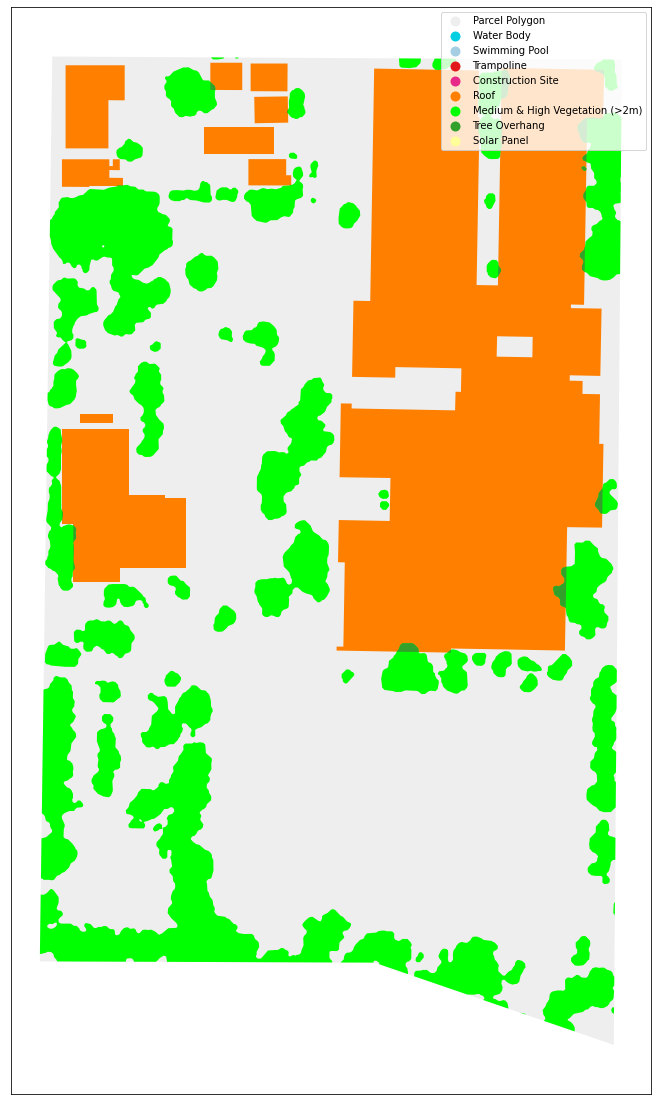

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
167,"MULTIPOLYGON (((-122.30498 47.62281, -122.30497 47.62281, -122.30496 47.6228...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6218172,-122.3060194,20.00z,0d/V/20200828",gen4-building_storm-1.0,0.576414,8949b7d4-1bbe-56ef-bdb2-131fd33f5fa8,,11.8,127.0,[],2020-08-28,2020-05-27
6,"POLYGON ((-122.30666 47.62313, -122.30666 47.62311, -122.30666 47.62311, -12...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6218172,-122.3060194,20.00z,0d/V/20200828",gen4-building_storm-1.0,0.974609,3c182468-2c2d-5af8-b99a-7227b4c9c98d,,579.8,6241.0,[],2020-08-28,2020-05-27
185,"MULTIPOLYGON (((-122.30592 47.62139, -122.30593 47.62139, -122.30594 47.6213...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6218172,-122.3060194,20.00z,0d/V/20200828",gen4-building_storm-1.0,0.981608,000554db-994f-5fcb-8a52-9b9dd4618553,,2206.8,23754.0,[],2020-08-28,2020-05-27
70,"MULTIPOLYGON (((-122.30685 47.62215, -122.30685 47.62213, -122.30685 47.6221...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6218172,-122.3060194,20.00z,0d/V/20200828",gen4-building_storm-1.0,0.932623,9e62d743-2cf6-5fd5-8305-9abac2832b15,,1627.2,17515.0,[],2020-08-28,2020-05-27
176,"MULTIPOLYGON (((-122.30531 47.62134, -122.30531 47.62135, -122.30530 47.6213...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@47.6218172,-122.3060194,20.00z,0d/V/20200828",gen4-building_storm-1.0,0.875695,6bd9f49c-d60d-5781-84cd-59b042cb3919,,161.5,1738.0,[],2020-08-28,2020-05-27


In [34]:
df_features = explore_example_parcel(4, df_parcels)
df_features.head()

## Wider Area Samples
Here, we expand to spend more credits in a single request, to get a larger area in one go. These make nice samples to showcase slightly larger chunks of our data.

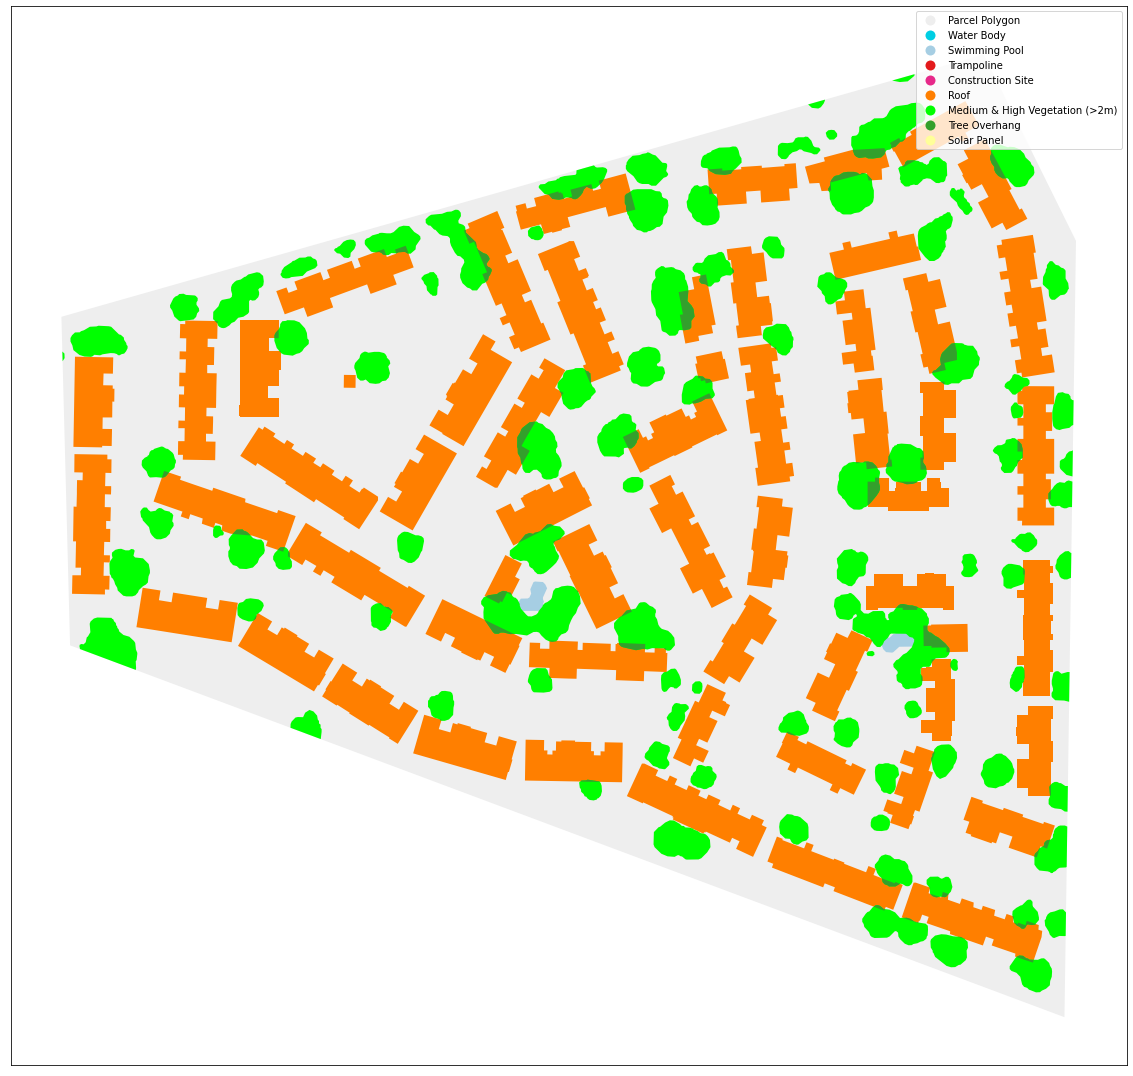

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
88,"POLYGON ((-96.88586 33.00240, -96.88586 33.00240, -96.88585 33.00241, -96.88...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0039895,-96.8874202,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.897799,b5a11dad-64da-5486-996a-d420a7c8f500,,7.5,81.0,[],2020-11-17,2020-11-03
53,"MULTIPOLYGON (((-96.88814 33.00403, -96.88813 33.00403, -96.88813 33.00403, ...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0039895,-96.8874202,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.596225,47b0ebb6-c8a3-5458-8bea-d50618689413,,33.1,356.0,[],2020-11-17,2020-11-03
303,"POLYGON ((-96.88596 33.00521, -96.88596 33.00521, -96.88597 33.00522, -96.88...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0039895,-96.8874202,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.580078,7603fe29-1f84-5f11-9abe-5391a4aa4256,,0.6,6.0,[],2020-11-17,2020-11-03
359,"MULTIPOLYGON (((-96.88845 33.00362, -96.88843 33.00362, -96.88843 33.00362, ...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0039895,-96.8874202,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.964753,02a03ccb-5d00-50d7-b918-e7a47c270789,,23774.3,255904.0,[],2020-11-17,2020-11-03
197,"POLYGON ((-96.88694 33.00283, -96.88693 33.00284, -96.88695 33.00285, -96.88...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0039895,-96.8874202,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.998047,47fa34f1-0eae-5bf0-9890-5cd28b50ba27,,521.1,5609.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03


In [35]:
df_features = explore_example_parcel(5, df_parcels)
df_features.head()

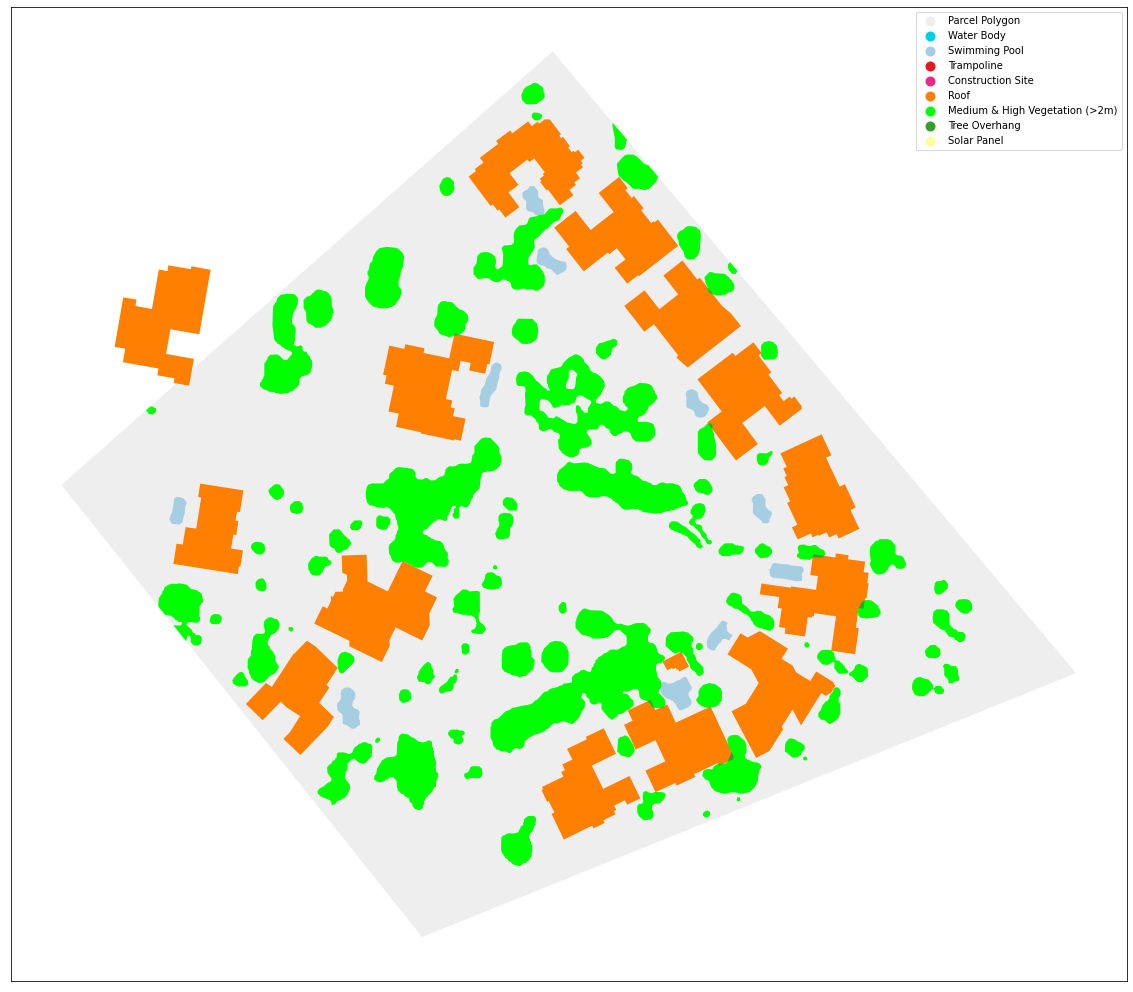

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
160,"POLYGON ((-96.90126 33.03513, -96.90126 33.03513, -96.90127 33.03515, -96.90...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0355739,-96.9030380,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.717265,89492987-7243-5726-989d-ba50333f3dae,,22.6,243.0,[],2020-11-17,2020-11-03
188,"POLYGON ((-96.90338 33.03613, -96.90338 33.03612, -96.90338 33.03611, -96.90...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0355739,-96.9030380,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.662109,5bf8f003-c3e9-52ca-8855-6c67a6eafcb9,,42.0,452.0,[],2020-11-17,2020-11-03
285,"POLYGON ((-96.90296 33.03493, -96.90289 33.03496, -96.90290 33.03496, -96.90...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0355739,-96.9030380,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.994141,ee8a318c-8c4c-5f8b-81c4-f90e0fc2dfc0,,541.2,5825.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03
292,"POLYGON ((-96.90425 33.03557, -96.90424 33.03566, -96.90425 33.03566, -96.90...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0355739,-96.9030380,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.998047,dc2a2010-2db3-5490-8fe1-febcb7976a0f,,433.0,4660.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03
233,"POLYGON ((-96.90276 33.03500, -96.90273 33.03501, -96.90275 33.03504, -96.90...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0355739,-96.9030380,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.998047,65505697-a406-5a3b-9fea-cafac1737795,,581.1,6255.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03


In [36]:
df_features = explore_example_parcel(6, df_parcels)
df_features.head()

For this example, we use the example function above to remove a "dangling" building (and all its children). Note how the building in the top left disappears below.

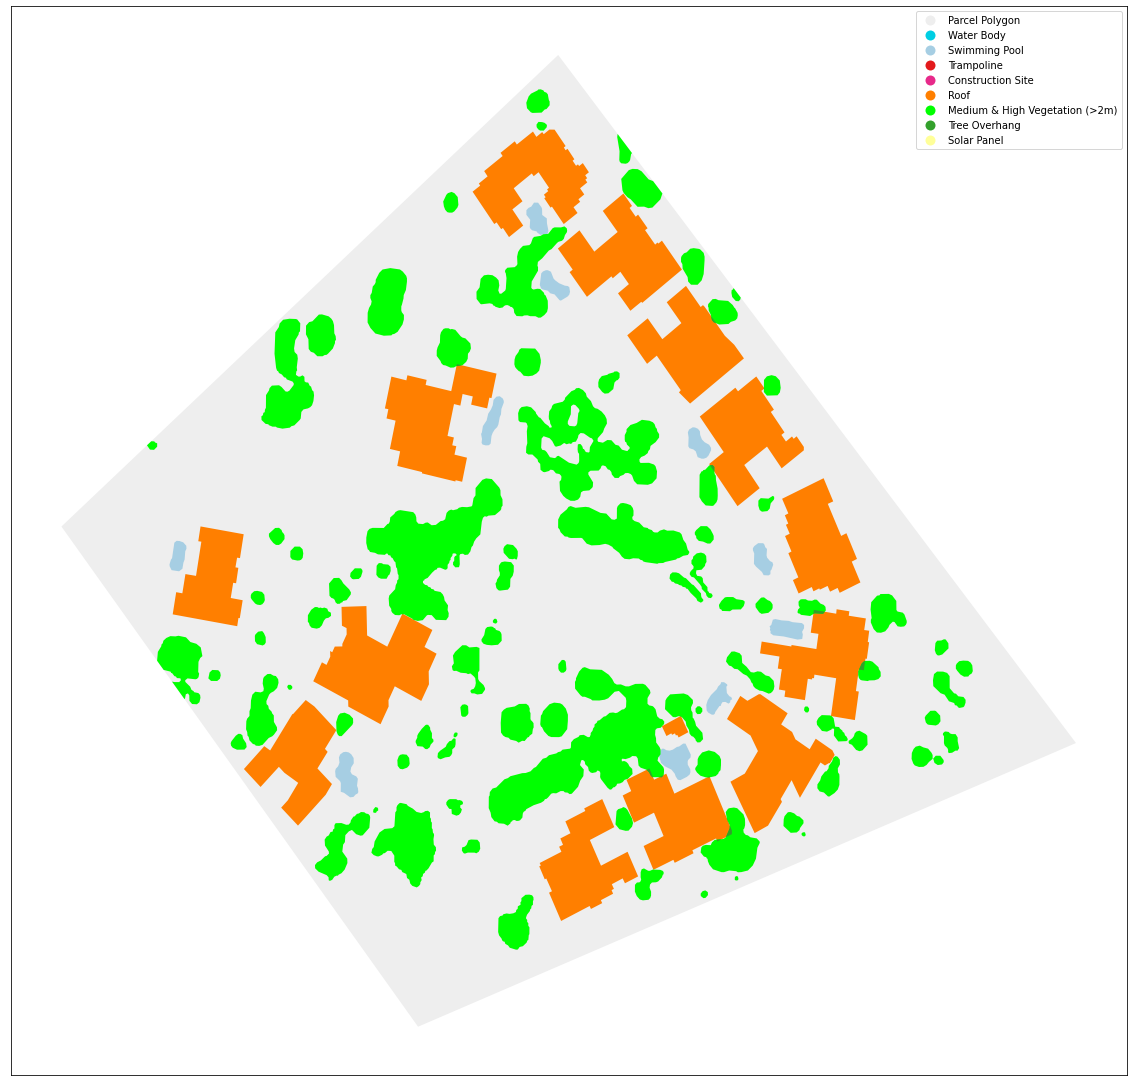

In [37]:
# Convert to the North American "Albers Equal Area" projection for more accurate areas
ALBERS_PROJ = 'ESRI:102008'
df_features = df_features.to_crs(ALBERS_PROJ)
df_features = remove_exterior_features(df_features, ALBERS_PROJ)
plot_query_aoi(df_features)

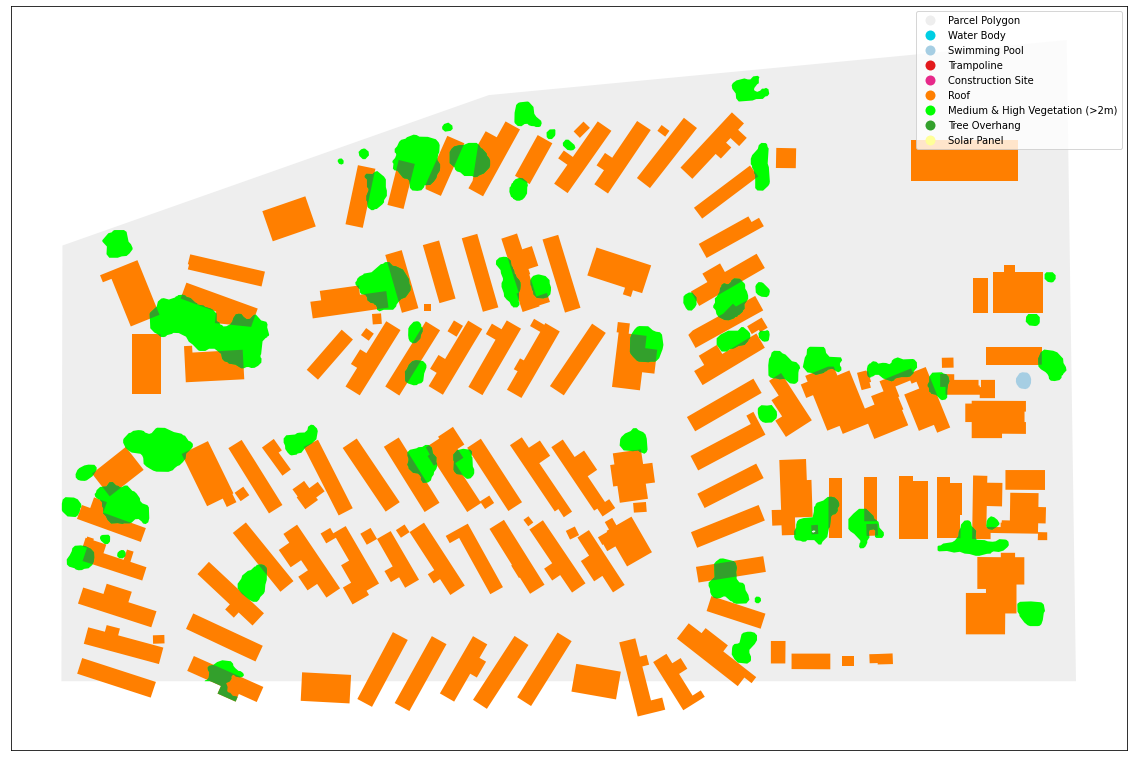

,geometry,description,classId,link,systemVersion,confidence,id,parentId,areaSqm,areaSqft,attributes,surveyDate,meshDate
224,"POLYGON ((-96.93626 33.03803, -96.93626 33.03802, -96.93626 33.03802, -96.93...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0374870,-96.9375905,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.525391,2f1eb3fc-3e8f-5046-805b-a197ad439e8c,,1.0,11.0,[],2020-11-17,2020-11-03
622,"MULTIPOLYGON (((-96.93932 33.03735, -96.93932 33.03735, -96.93933 33.03736, ...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0374870,-96.9375905,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.921449,04d04fc2-25e3-5c38-ad70-65593fc55a4f,,1074.0,11561.0,[],2020-11-17,2020-11-03
244,"MULTIPOLYGON (((-96.93861 33.03675, -96.93860 33.03675, -96.93860 33.03675, ...",Asphalt,97a1f8a8-7cf2-4e81-82b4-753ee225d9ed,"https://apps.nearmap.com/maps/#/@33.0374870,-96.9375905,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.663847,6a41a6ca-550d-5d13-9b59-c6ac4a1b65d2,,115.7,1245.0,[],2020-11-17,2020-11-03
360,"POLYGON ((-96.93758 33.03716, -96.93760 33.03716, -96.93774 33.03734, -96.93...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0374870,-96.9375905,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.978516,c4c25287-5329-5d54-9636-95a6ddd10430,,142.8,1537.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03
459,"POLYGON ((-96.93610 33.03757, -96.93629 33.03757, -96.93629 33.03762, -96.93...",Building,a2e4ae39-8a61-5515-9d18-8900aa6e6072,"https://apps.nearmap.com/maps/#/@33.0374870,-96.9375905,20.00z,0d/V/20201117",gen4-building_storm-1.0,0.966797,8bc05a8f-51e1-5c5a-b24c-1996a9623e13,,94.1,1013.0,"[{'classId': '19e49dad-4228-554e-9f5e-c2e37b2e11d9', 'description': 'Buildin...",2020-11-17,2020-11-03


In [38]:
df_features = explore_example_parcel(7, df_parcels)
df_features.head()

# Multi Request Grids - Using the AI Features API to build an Offline Map
Compositing many requests into a single contiguous area. By creating a grid of squares, pulling the results, and deduplicating on `id` and geometry, it is possible to use the API to create a contiguous map of a whole area of interest that is unbounded (for example, a local government area). Care should be taken on large areas where survey overlaps may be encountered, as the unique ID of objects does not persist between surveys - so deduplication requires more effort. The below code demonstrates one way of dealing with that for buildings.

In [39]:
def fetch_multipolygon_aoi(df_request_polygons, out_name='', save=False, since=SINCE, until=UNTIL, packs=PACKS):
    '''
    Taking a geopandas data frame where each row represents a polygon (e.g. a contiguous grid), and merging results into a single geodataframe with deduplicated features. This can allow grabbing a much larger area than a single request will permit.
    '''
    df_features_all = []
    for row in tqdm.tqdm(df_request_polygons.itertuples(), total=len(df_request_polygons)):
        poly_obj = row.geometry
        polygon = poly2coordstring(poly_obj)
        desc = row.description
        request_string = f"{FEATURES_URL}?polygon={polygon}&since={since}&until={until}&packs={packs}&apikey={API_KEY}"
        logging.info(request_string.split('&apikey')[0])
        t1 = time.time()
        payload = get_payload(request_string)
        t2 = time.time()
        logging.info(f'Time to retrieve payload: {t2-t1:0.2f}s')
        if payload is not None:
            logging.info(f'Credits used: {payload["credits"]}')
            logging.info(f'System version: {payload["systemVersion"]}')
            df_features = process_payload(payload, poly_obj, f'sample_payload_{desc}', save=False)            
            df_features_all.append(df_features)
    df_features_all = pd.concat(df_features_all)
    
    # deduplicate identical features, and remove grid:
    df_features_all = df_features_all.loc[~df_features_all.duplicated(subset=('id', 'geometry'))]
    df_features_all = df_features_all.query('classId != 0')
    if out_name != '' and save:
        df_features_saveable = (df_features_all.assign(
            description=df_features_all.description.astype('str'),
        ))
        if len(df_features_all) > 1: # Not just parcel polygon
            df_features_saveable['attributes'] = df_features_saveable.attributes.apply(lambda j: json.dumps(j, indent=2)) # Render attributes as string so it can be saved as a geopackage
        df_features_saveable.to_file(f"{out_name}.gpkg", driver="GPKG")
    return df_features_all

def load_saved_aoi(filename):
    '''
    Loads up a saved geopackage to save hitting the API again.
    '''
    load_filename = filename
    print(filename)
    if len(os.path.splitext(filename)[-1]) == 0:
        load_filename = f'{filename}.gpkg'
    df = gpd.read_file(load_filename)
    df['attributes'] = df.attributes.apply(lambda s: json.loads(s))
    df['description'] = pd.Categorical(df.description)
    return df

def get_building_char(attribs):
    '''
    Get building characteristic info from attribs field of a "Building" feature.
    '''
    if len(attribs) == 1:
        building_3d_attribs = attribs[0]
        assert building_3d_attribs['classId'] == '19e49dad-4228-554e-9f5e-c2e37b2e11d9'
        height = building_3d_attribs['height']
        df_storeys = pd.Series(building_3d_attribs['numStories'])
        most_likely_storeys = df_storeys.index[df_storeys.argmax()]
        most_likely_confidence = df_storeys[most_likely_storeys]
        if most_likely_confidence < 1/3:
            most_likely_storeys = 'UNKNOWN'    
        return (most_likely_storeys, most_likely_confidence, height)
    else:
        return None

def get_roof_char(attribs):
    '''
    Get roof characteristic info from attribs field of a "Building" feature.
    '''
    out_attribs = {}
    
    for row in attribs:

        if row['classId'] == '89c7d478-58de-56bd-96d2-e71e27a36905': #'Roof material'
            for material_component in row['components']:
                material = material_component['description']
                out_attribs[f'{material}_ratio'] = material_component['ratio']
                out_attribs[f'{material}_area_m2'] = material_component['area']
                out_attribs[f'{material}_confidence'] = material_component['confidence']

        elif row['classId'] == '20a58db2-bc02-531d-98f5-451f88ce1fed': #'Roof types'
            for type_component in row['components']:
                roof_type = type_component['description']
                out_attribs[f'{roof_type}_ratio'] = type_component['ratio']
                out_attribs[f'{roof_type}_area_m2'] = type_component['area']
                out_attribs[f'{roof_type}_confidence'] = type_component['confidence']

        elif row['classId'] == '39072960-5582-52af-9051-4bc8625ff9ba': #'Roof 3D attribs'
            if row['has3dAttributes']:
                out_attribs['pitch'] = row['pitch']
    return out_attribs


def remove_intersecting_buildings(df):
    '''
    This is useful if needing to merge multiple API requests from surveys on different dates (as the feature ID is only unique within a date), e.g. at survey boundaries.
    It identifies any buildings that physically overlap with each other, and keeps the best one from each overlapping group - where we first preference the result with
    valid 3D data attached, and then find the highest confidence building remaining.
    
    This is NOT necessary for single API requests, which always contain results from a single survey. Errors are returned if an API request does not have complete coverage by one survey within the date range.
    
    NB: This function is currently specific to BUILDINGS, as it uses an attribute only present on the building. Ideally, for each removed building, removals would cascade to all features (such as roofs) that descend from it.
    '''
    multipoly = df.unary_union
    
    # Make a gpd dataframe of all merged polygons
    df_groups = gpd.GeoDataFrame(crs=df.crs, geometry=gpd.GeoDataFrame(multipoly).loc[:,0])
    df_groups['group'] = df_groups.index
    df_joined = gpd.sjoin(df, df_groups, op='intersects', how='left')
    
    # Prioritise things with largest area (not cut off), a valid storey estimate, then highest confidence building.
    df_joined['has3D'] = df_joined.attributes.apply(lambda d: d[0]['has3dAttributes'])
    df2 = df_joined.sort_values(['has3D', 'confidence', 'area'], ascending=False).groupby(by='group')
    
    df3 = []
    for i, g in df2:
        date_summary = g.groupby('surveyDate').aggregate(dict(
            area=sum,
            confidence=max,
            has3D=max,
        )).sort_values(['has3D', 'confidence', 'area'], ascending=False)
        keep_date = date_summary.iloc[0].name
        df3.append(g.query('surveyDate == @keep_date'))    
    df3 = pd.concat(df3)
    return df3


def split_and_save_features(df_features_all, save_name, fuzzy_dedup=False):
    '''
    Break a dataframe of features into a geopackage for each feature class, with relevant attributes flattened and saved for each one.
    '''
    out_dfs = []
    for description, df in df_features_all.groupby('description'):
        logging.info(description)

        if description in ('Building', 'Roof', 'Trampoline', 'Solar Panel', 'Swimming Pool', 'Construction Site', 'Tree Overhang'):
            # Can be deduplicated based on ID, as they aren't cropped to query boundary.
            df = df.loc[~df.duplicated(subset='id'), :]
        
        if description == 'Building':
            # Buildings can be deduplicated based on ID, as they aren't cropped to query boundary.
            if fuzzy_dedup:
                df = remove_intersecting_buildings(df)
                
            df_3d = df.attributes.apply(lambda d: pd.Series(get_building_char(d)))
            if len(df_3d.columns) == 3:
                df['storeys'] =  df_3d[0]
                df['storeys_confidence'] =  df_3d[1]
                df['peak_height_m'] =  df_3d[2]
            elif len(df_3d.columns) == 1:
                logging.info('No building 3D data found')
            else:
                logging.warning('Unexpected number of 3D attributes on buildings')
            
        elif description == 'Roof':
            if fuzzy_dedup:
                logging.warning('No fuzzy dedup yet for roofs')
                
            df_roof_chars = df.attributes.apply(lambda d: get_roof_char(d)).apply(pd.Series)
            df = pd.concat([df, df_roof_chars], axis=1)

        out_dfs.append(df)
        if (save_name != '') & (len(df) > 0):
            df['description'] =  df.description.astype('str')
            df['attributes'] = df.attributes.apply(lambda j: json.dumps(j, indent=2)) # Render attributes as string so it can be saved as a geopackage
            df.to_file(f"{save_name}_{description}.gpkg", driver="GPKG")
    return out_dfs

In [ ]:
logging.root.setLevel(logging.WARNING)
out_name = 'GEOJSON_FILENAME'
df_grid = gpd.read_file(f'{out_name}.geojson').to_crs('EPSG:4326')
df_grid['description'] = df_grid.index
df_grid

In [ ]:
df_features_all = fetch_multipolygon_aoi(df_grid, out_name=out_name, save=False, packs=PACKS)
df_features_all.plot()
df_features_all.shape

In [ ]:
%%time
out_dfs = split_and_save_features(df_features_all, out_name, fuzzy_dedup=False)